# Metric Analysis - Part:2

### Overview
The purpose of this notebook is to predict the metric using SARIMA model. 

Broadly we have 3 types of Analytics -

1. **Descriptive Analytics**
2. **Predictive Analytics**
3. **Prescriptive Analytics**

In this notebook, we focus on the **Predictive Analytics** part.

### Style Settings

In [231]:
%matplotlib inline

# CSS File
from IPython.core.display import HTML
from IPython.display import Image

# Libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime as dt
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter
from seasonal import fit_seasons, adjust_seasons, fit_trend

import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
#import statsmodels.api as sm

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Libraries

In [232]:
def read_metric_data(metric_name, csv_name):
    '''
        Read metric data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
        
    #print("{0} - #Observations: {1}".format(csv_name, df.shape))
    return df

def describe_metric(metric_name, df):
    '''
        Generate custom summary of the data
    '''
    summary = df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95])
    summary.columns = [metric_name]
    summary = summary.applymap('{:.2f}'.format) # URL: https://pyformat.info/
    #summary['value'] = summary['value'].map('{:.2f}'.format) 
    #summary.drop(labels=['count'], axis=0, inplace=True)
    summary.loc['frequent'] = df.mode().value[0]
    summary.loc['skewness'] = df.value.skew()
    summary.loc['kurtosis'] = "{0:.2f}".format(round(df.value.kurtosis(), 2))
    summary = summary.rename(index={'count': 'samples', 'mean':'average', 'std':'std dev', 'min':'lowest', 'max':'highest'})
    return summary

### Configuration

In [233]:
metric_name = "Disk Utilization (%)"
csv_name = 'data/du_7d.txt'

print("metric_name:\t{0}, \ndata_filename:\t{1}".format(metric_name, csv_name))

metric_name:	Disk Utilization (%), 
data_filename:	data/du_7d.txt


### Visual Analysis

In [234]:
# Load data
df1 = read_metric_data(metric_name, csv_name)
df1.value = df1.value.round(3)

# Create Summary
summary = describe_metric(metric_name, df1)
summary.T

,samples,average,std dev,lowest,5%,25%,50%,75%,95%,highest,frequent,skewness,kurtosis
Disk Utilization (%),168.00,0.11,0.01,0.10,0.10,0.11,0.11,0.11,0.13,0.16,0.107,3.01926,10.34


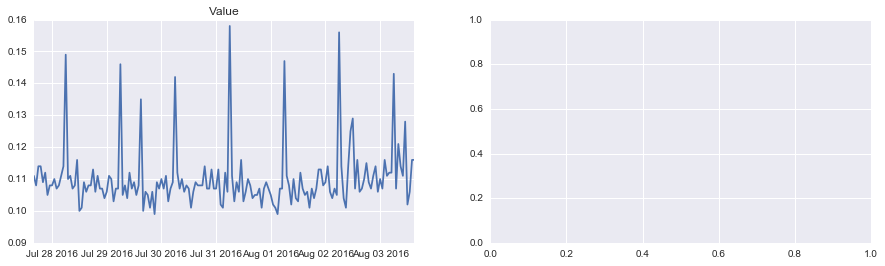

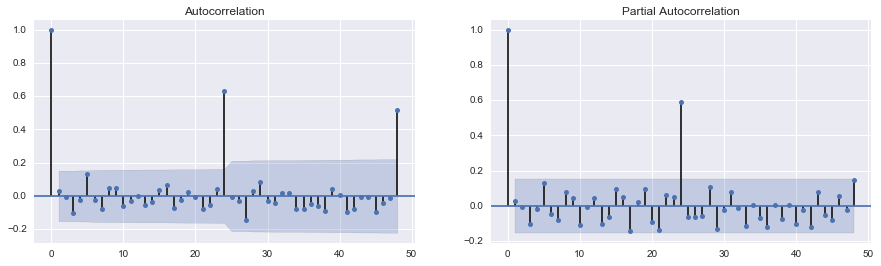

In [241]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Levels
axes[0].plot(df1.index, df1.value)
axes[0].set(title='Value')

# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(df1.ix[1:, 'value'], lags=48, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df1.ix[1:, 'value'], lags=48, ax=axes[1])

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood                 513.224
Date:                            Wed, 03 Aug 2016   AIC                          -1014.449
Time:                                    17:20:59   BIC                           -995.705
Sample:                                07-27-2016   HQIC                         -1006.842
                                     - 08-03-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    9.22e-05      0.000      0.445      0.656      -0.000       0.000
ar.L1         -0.1900      0.128   

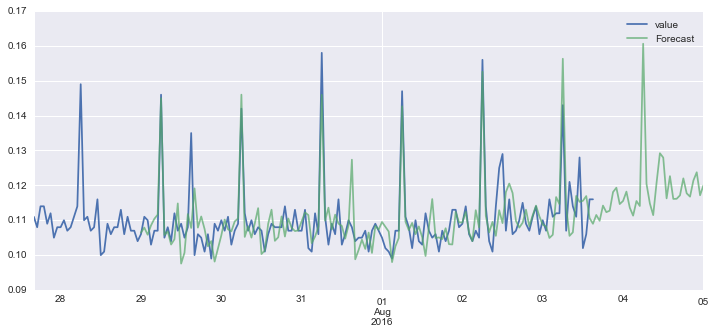

In [244]:
# Fit the model
mod = sm.tsa.SARIMAX(df1['value'], trend='c', order=(1,1,1), seasonal_order=(1,1,1,24))
res = mod.fit()
print res.summary()

predict = res.predict('2016-07-29','2016-08-5', typ='levels')
#print(arima_predict)
ax = df1.plot(label='observed', figsize=(12,5))
predict.plot(ax=ax, label='Forecast', alpha=.7)
plt.legend()
sns.despine()

In [230]:
predict.head()

2016-07-29 00:00:00    0.106453
2016-07-29 01:00:00    0.107892
2016-07-29 02:00:00    0.105852
2016-07-29 03:00:00    0.108502
2016-07-29 04:00:00    0.110415
Freq: H, dtype: float64